In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from shapely.geometry import box
import geopandas as gpd
import geoplot as gplt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import os.path
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 16]

# Government of Ontario COVID data 
# Base URL of the public facing website
BASE_URL = "https://data.ontario.ca/dataset"
# Names of datasets, which we can use to fetch CSVs
DATASETS = [
    "Status of COVID-19 cases in Ontario", "Confirmed positive cases of COVID-19 in Ontario"
]

# Local folder to save case data
FOLDER_TEST_DATA = "data"
FOLDER_SHAPEFILES = "shapefiles"

In [2]:
GOVERNMENT_INTERVENTIONS = [
    {
        "date": "2020-03-17", 
        "action": "State of emergency"
    }, 
    #    {
    #    "date": "2020-03-20", 
    #    "action": "US border closed"
    #}, 
        {
        "date": "2020-03-24", 
        "action": "Non-essential\nbusinesses closed"
    }, 
            {
        "date": "2020-04-03", 
        "action": "Non-essential\nbusiness list\nbroadened"
    }, 
]

# Get and clean case data

In [3]:
def get_website_url(dataset_name):
    """
    Return the URL of the public-facing website on COVID from the Government of Ontario.
    
    Parameter
    =========
    dataset_name: str
        The name of the dataset.
        
    Return
    ======
    str
        The URL of the public-facing website to scrape the CSV locations from.
    """
    url_title = dataset_name.lower().replace(" ", "-") 
    url_website = "/".join([BASE_URL, url_title])
    return url_website

In [4]:
def get_data_urls(url_website):
    """
    Return the URLs of test data hosted by the Government of Ontario.
    
    Parameters
    ==========
    url_website: str
        The URL of the public-facing website on COVID from the Government of Ontario.
        
    Return
    ======
    url_test_data: list of str
        List of URLs for CSVs hosted on the site
    """
    response = requests.get(url_website, headers={"User-Agent": "Requests"})
    soup = BeautifulSoup(response.text, "html.parser")
    urls_html = soup.findAll("a", class_="resource-url-analytics btn btn-primary dataset-download-link")
    urls_data = [u["href"] for u in urls_html]
    return urls_data

In [5]:
def fetch_test_data(urls_test_data):
    """
    Get and save today's Ontario COVID data. If it already exists, don't download again.
    
    Parameters
    ==========
    url_test_data: list of str
        URL to the CSV of today's COVID data.
    
    Return
    ======
    filepaths_test_data: list of str
        Local paths to the CSV files containing the COVID data.
    """
    date_iso = pd.to_datetime('now').strftime("%Y-%m-%d")
    date_folder = os.path.join(FOLDER_TEST_DATA, date_iso)
    if not os.path.exists(date_folder):
        os.mkdir(date_folder)
    
    filepaths_test_data = []
    for url in urls_test_data:
        basename_covid_data = os.path.basename(url)
        filename_covid_data = os.path.join(date_folder, basename_covid_data)
        
        if not os.path.exists(filename_covid_data):
            print(f"File doesn't exist: {filename_covid_data}.\nDownloading from {url}.")
            http_response = requests.get(url)
            with open(filename_covid_data, "wb") as f:
                f.write(http_response.content)
        else: 
            print(f"File already exists: {filename_covid_data}. Skipping download.")
        filepaths_test_data.append(filename_covid_data)
    
    return filepaths_test_data

In [6]:
def load_test_data(filename_test_data):
    """
    Load case data into memory.
    
    Parameters
    ==========
    filename_test_data: str
        Path to the CSV files containing the COVID data.
    
    Return
    ======
    tests: DataFrame
        The COVID case count data.
    """
    with open(filename_test_data, "rb") as f:
        tests = pd.read_csv(f)
    return tests

In [7]:
def clean_test_data(tests):
    """
    Clean the case data.
    
    Parameters
    ==========
    tests: DataFrame
        The COVID case count data.
        
    Return
    ======
    tests_cleaned: DataFrame
        The COVID case count data, cleaned.
    """
    df = tests.copy()
    df = df.set_index("Reported Date")
    df.index = pd.to_datetime(df.index)
    df = df.fillna(0)
    df = df.astype(int)
    tests_cleaned = df
    return tests_cleaned

# Download today's data for both datasets

In [8]:
for dataset in DATASETS:
    print(f"Downloading files from the dataset {dataset}")
    url_website = get_website_url(dataset)
    url_dataset = get_data_urls(url_website)
    path_dataset = fetch_test_data(url_dataset)

File already exists: data/2020-04-24/covidtesting.csv. Skipping download.
File already exists: data/2020-04-24/conposcovidloc.csv. Skipping download.
File already exists: data/2020-04-24/conposcovidloc.geojson. Skipping download.


# Investigate Summary dataset: Status of COVID-19 cases

In [9]:
dataset = "Status of COVID-19 cases in Ontario"
url_website = get_website_url(dataset)
url_dataset = get_data_urls(url_website)
path_dataset = fetch_test_data(url_dataset)[0]
case_status = load_test_data(path_dataset)
tests = clean_test_data(case_status)

File already exists: data/2020-04-24/covidtesting.csv. Skipping download.


In [10]:
tests.tail()

,Confirmed Negative,Presumptive Negative,Presumptive Positive,Confirmed Positive,Resolved,Deaths,Total Cases,Total patients approved for testing as of Reporting Date,Total tests completed in the last day,Under Investigation,Number of patients hospitalized with COVID-19,Number of patients in ICU with COVID-19,Number of patients in ICU on a ventilator with COVID-19
Reported Date,,,,,,,,,,,,,
2020-04-19,0,0,0,4816,5209,553,10578,156097,9643,5736,809,247,196
2020-04-20,0,0,0,5085,5515,584,11184,164840,8743,3799,802,247,193
2020-04-21,0,0,0,5307,5806,622,11735,174170,9330,5546,859,250,194
2020-04-22,0,0,0,5365,6221,659,12245,184531,10361,6845,878,243,192
2020-04-23,0,0,0,5486,6680,713,12879,194745,10214,6757,887,233,185


## Plot: fractional change in active cases over time

In [11]:
def add_government_interventions_to_plot(ax, government_interventions):
    """
    Add vertical lines corresponding to government interventions to an axes.
    
    Parameters:
    ===========
    ax: matplotlib axes
        The axes to add the lines to
        
    government_interventions: list of dict
        The interventions to plot. Each list item must have keys:
            date: str, ISO-8601
                The date of the intervention
            action: str
                The text to print to describe the action
                
    Return:
    =======
    The axes with the lines added
    """
    y_pos_initial = 0.35
    y_pos_diff = 0.05
    x_pos_pad = pd.Timedelta(days=0.5)
    
    for n, intervention in enumerate(government_interventions):
        x_pos = pd.to_datetime(intervention["date"])
        y_pos = y_pos_initial - n * y_pos_diff
        
        ax.axvline(
            x_pos, 
            color="salmon", 
            linewidth=3, 
            alpha=0.75)
        
        plt.text(
            x_pos + x_pos_pad, 
            y_pos, 
            intervention["action"], 
            fontsize=12,
            color="tomato",
            transform=ax.get_xaxis_transform()
        )
    return ax

In [12]:
def plot_fractional_change(time_series, start_date, plot_labels={}, government_interventions=[]):
    """
    Plot the fractional change of a metric compared to the previous day. 
    Optionally, add vertical lines for government interventions
    
    Parameters
    ==========
    time_series: Series
        Time series with a datetimeindex
        
    start_date: str, in ISO8601
        The date to start the timeline. 
        
    plot_labels: dict of str
        Descriptions of what the plot means. Both are optional.
            title: str
            subtitle: str
        
    government_interventions: list of dict
        The interventions to plot. Each list item must have keys:
            date: str, ISO-8601
                The date of the intervention
            action: str
                The text to print to describe the action
    Return 
    ======
    fig: matplotlib.figure.Figure
        Contains two Axes: total per day, change per day.
    """
    # Calculate the fractional change, and rolling average
    ts = time_series
    ts = ts/ts.shift(1)
    ts_avg = ts.rolling(7).mean()

    fig, ax = plt.subplots(figsize=(20, 10))
    
    ax.plot(ts, "o",
            color="mediumblue",
            label="Daily change")
    ax.plot(ts_avg, "--", 
            color="cornflowerblue",
            linewidth=3,
            label="Rolling average (7 days)")
    ax.axhline(1, color="mediumseagreen", alpha=0.5, linewidth=3)

    small_font = 12
    medium_font = 16
    large_font = 18

    ax.set_ylim(0.5, 1.5)
    ax.set_xlim(pd.to_datetime([start_date, 'now']))

    # Plot government interventions
    if government_interventions:
        ax = add_government_interventions_to_plot(ax, government_interventions)

    # Add title, and subtitle if it exists
    title = plot_labels.get("title", f"Fraction of {ts.name} compared to the previous day")
    if plot_labels.get("subtitle"):
        fig.suptitle(title, fontsize=large_font, y=0.93)
        ax.set_title(plot_labels["subtitle"], fontsize=small_font, style="italic")
    if not plot_labels.get("subtitle"):
        ax.set_title(title, fontsize=large_font)
    
    ax.set_ylabel("Fraction", rotation=0, labelpad=60, fontsize=medium_font)
    ax.set_xlabel("Date", fontsize=medium_font)
    ax.tick_params(labelsize=small_font)
    ax.legend(fontsize=medium_font, fancybox=True)

    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.25))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%B %-d"))
    ax.xaxis.set_major_locator(mdates.DayLocator([1,15]))
    ax.xaxis.grid(True, which="major")

    fig.autofmt_xdate()
    return fig

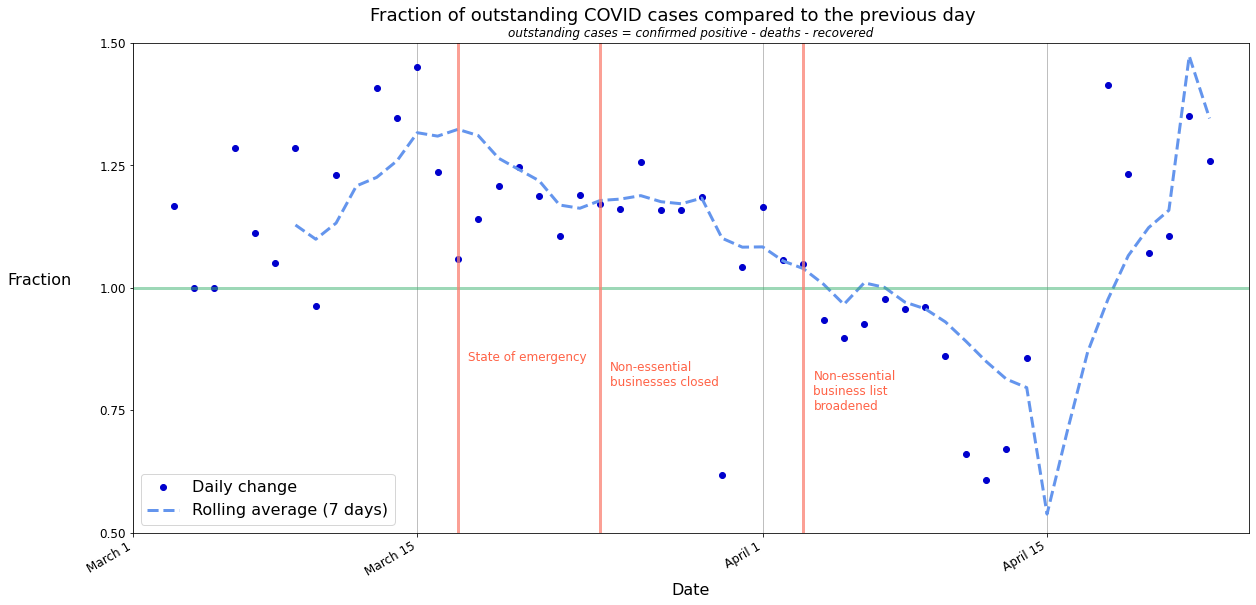

In [13]:
# Outstanding cases are confirmed positives that have not ended in: deaths, resolved
time_series = tests["Confirmed Positive"] - tests["Deaths"] - tests["Resolved"]
start_date = "2020-03-01"
plot_labels = {
    "title": "Fraction of outstanding COVID cases compared to the previous day",
    "subtitle": "outstanding cases = confirmed positive - deaths - recovered"
}

fig = plot_fractional_change(time_series, start_date, plot_labels=plot_labels, government_interventions=GOVERNMENT_INTERVENTIONS)
plt.show()

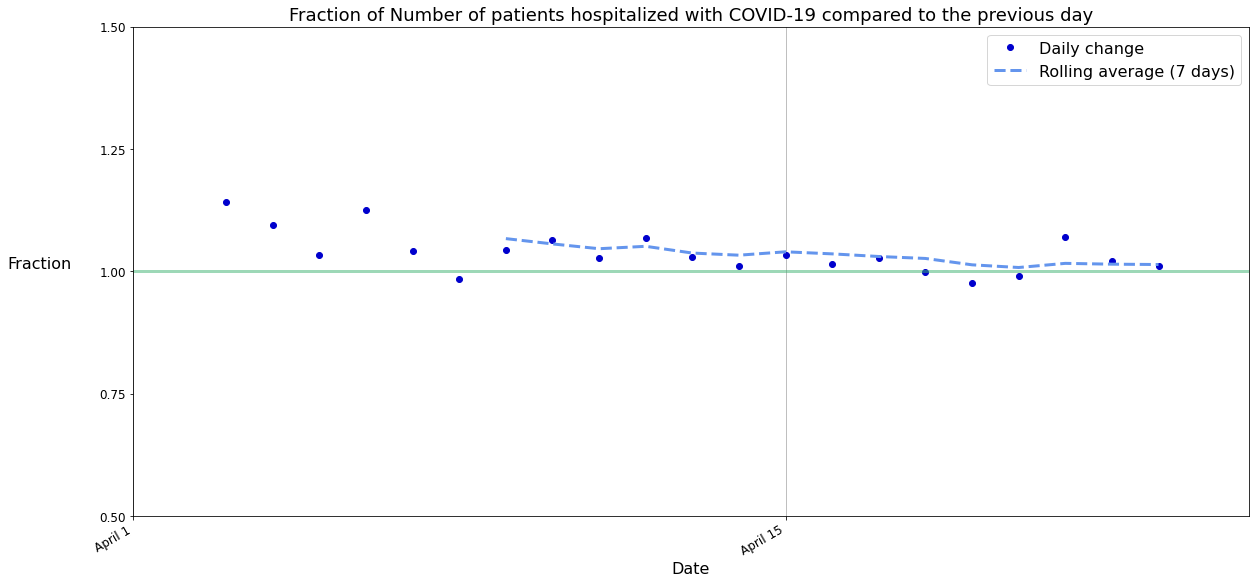

In [14]:
# Outstanding cases are confirmed positives that have not ended in: deaths, resolved
time_series = tests["Number of patients hospitalized with COVID-19"]
start_date = "2020-04-01"
fig = plot_fractional_change(time_series, start_date)
plt.show()

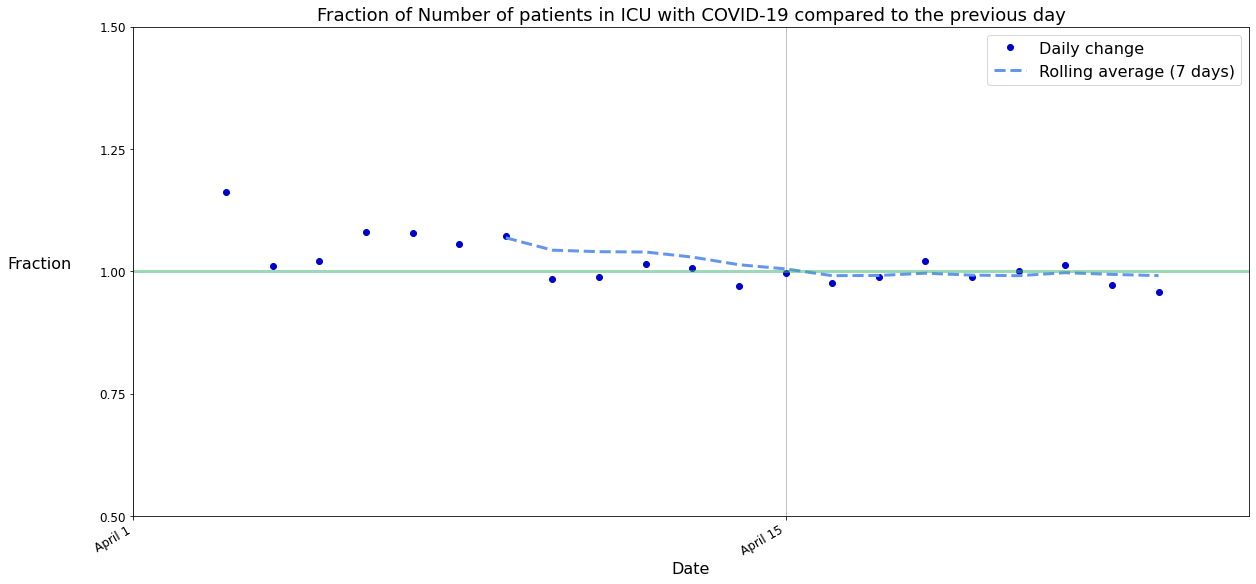

In [15]:
time_series = tests["Number of patients in ICU with COVID-19"]
start_date = "2020-04-01"
fig = plot_fractional_change(time_series, start_date)
plt.show()

## Plot: case count timeseries

In [16]:
def plot_timeline(time_series, start_date, colormap="rainbow"):
    """
    Make a pretty plot of a timeseries.
    
    Parameters
    ==========
    time_series: DataFrame
        Table with a datetimeindex
        
    start_date: str, in ISO8601
        The date to start the timeline. 
        
    Return 
    ======
    fig: matplotlib.figure.Figure
        Contains two Axes: total per day, change per day.
    """
    cmap = plt.get_cmap(colormap)
    
    fig, [ax_total, ax_change] = plt.subplots(nrows=2, ncols=1, figsize=(20, 14))
    
    axes = {"total": ax_total, "change": ax_change}
    text = {
        "total": {
            "title": "Total per day", 
            "ylabel": "# Cases", "xlabel": "Date"
        },
        "change": {
            "title": "Change per day", 
            "ylabel": "# Cases", "xlabel": "Date"
        }
    }
        
    time_series.index = pd.to_datetime(time_series.index)
    ts = {"total": time_series, "change": time_series - time_series.shift(1)}
    
    # Iterate over the two kinds of graph: total, and change
    for name, ax in axes.items():          
        # Restrict range in x-axis
        x_data_max = pd.to_datetime(start_date)
        if name == "change":
            x_data_max = x_data_max + pd.DateOffset(1)

        df = ts[name]
        df_plot = df[df.index >= x_data_max]
        
        colors = cmap(np.linspace(0, 1, len(df_plot.columns)))
        bar_below = pd.Series(data=0, index=df_plot.index)
        # Iterate over the columns selected
        for col, c in zip(df_plot, colors):
            if name == "total":
                ax.bar(
                    x=df_plot.index,
                    height=df_plot[col],
                    label=col,
                    color=c,
                    bottom=bar_below
                )
                bar_below = bar_below + df_plot[col]
            if name == "change":
                ax.plot(
                    df_plot[col], 
                    linewidth=0,
                    marker="o",
                    markersize="7",
                    alpha=0.75,
                    # label=col,
                    color=c
                )
                ax.plot(
                    df_plot[col].rolling(7).mean(), 
                    linewidth="3",
                    linestyle="-",
                    markersize="0",
                    alpha=1,
                    label=f"{col} average",
                    color=c
                )
                ax.axhline(
                    0, 
                    linewidth="2",
                    color="grey"
                )
        
        ax.set_xlim([pd.to_datetime(start_date), ts[name].index.max() + pd.DateOffset(1)])
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%B %-d"))
        ax.xaxis.grid(True, which="major")

        ax.set_title(text[name]["title"])
        ax.legend()

    fig.autofmt_xdate()
    return fig

### Morbid measures

In [17]:
morbid_cols = {
    "Number of patients hospitalized with COVID-19": "hospital",
    "Number of patients in ICU with COVID-19": "icu",
    "Number of patients in ICU on a ventilator with COVID-19": "ventilator",
    "Deaths": "deaths"
}
morbid = tests[morbid_cols].rename(columns=morbid_cols)

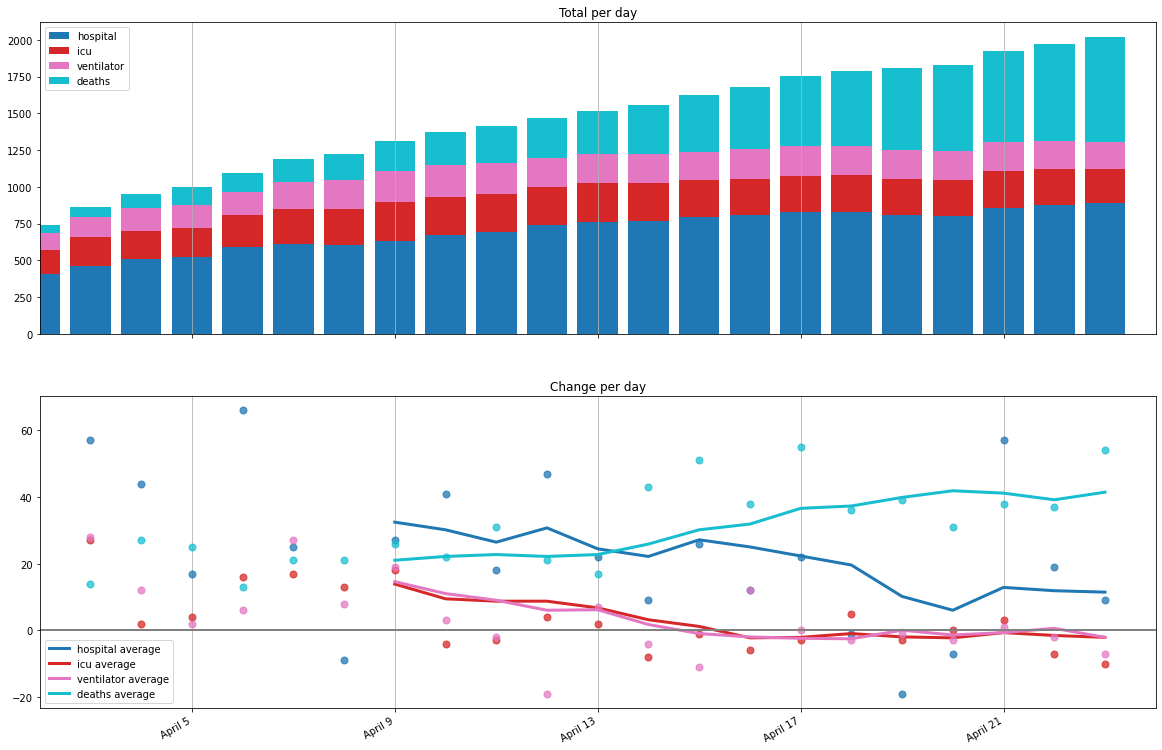

In [18]:
fig = plot_timeline(morbid, "2020-04-02", colormap="tab10")
plt.show()

### Case volume

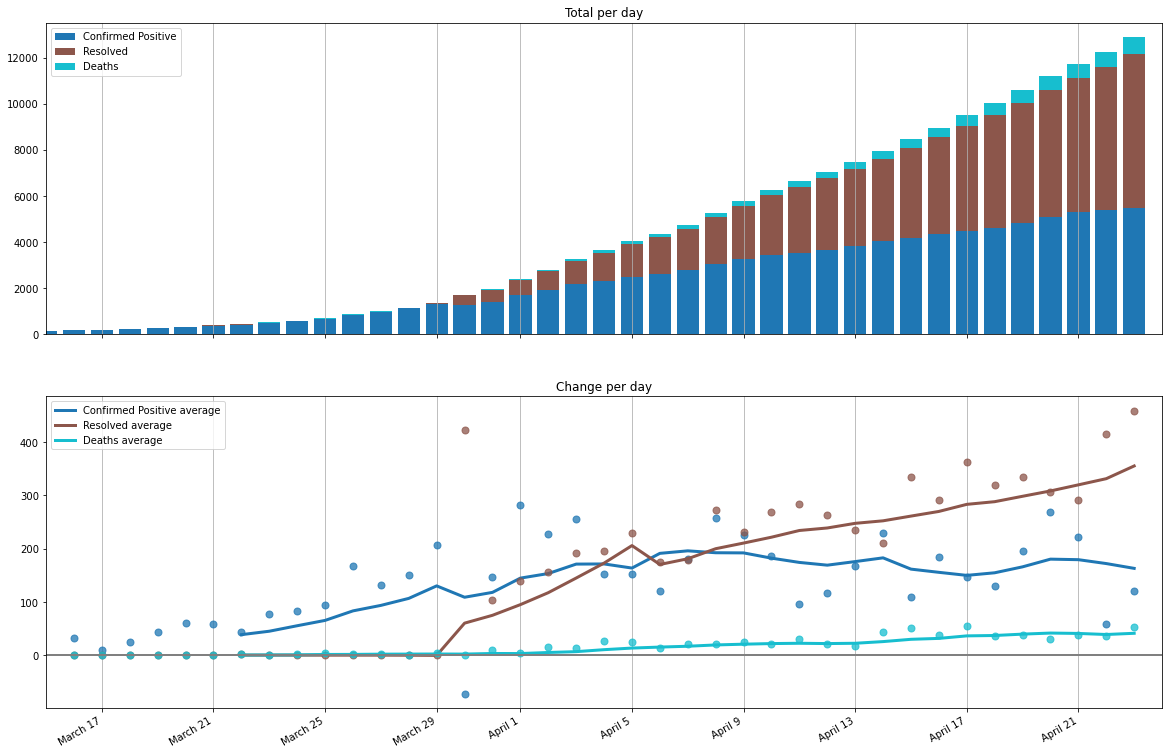

In [19]:
case_cols = ["Confirmed Positive", "Resolved", "Deaths"]
cases = tests[case_cols]
fig = plot_timeline(cases, "2020-03-15", colormap="tab10")
plt.show()

### Testing volume

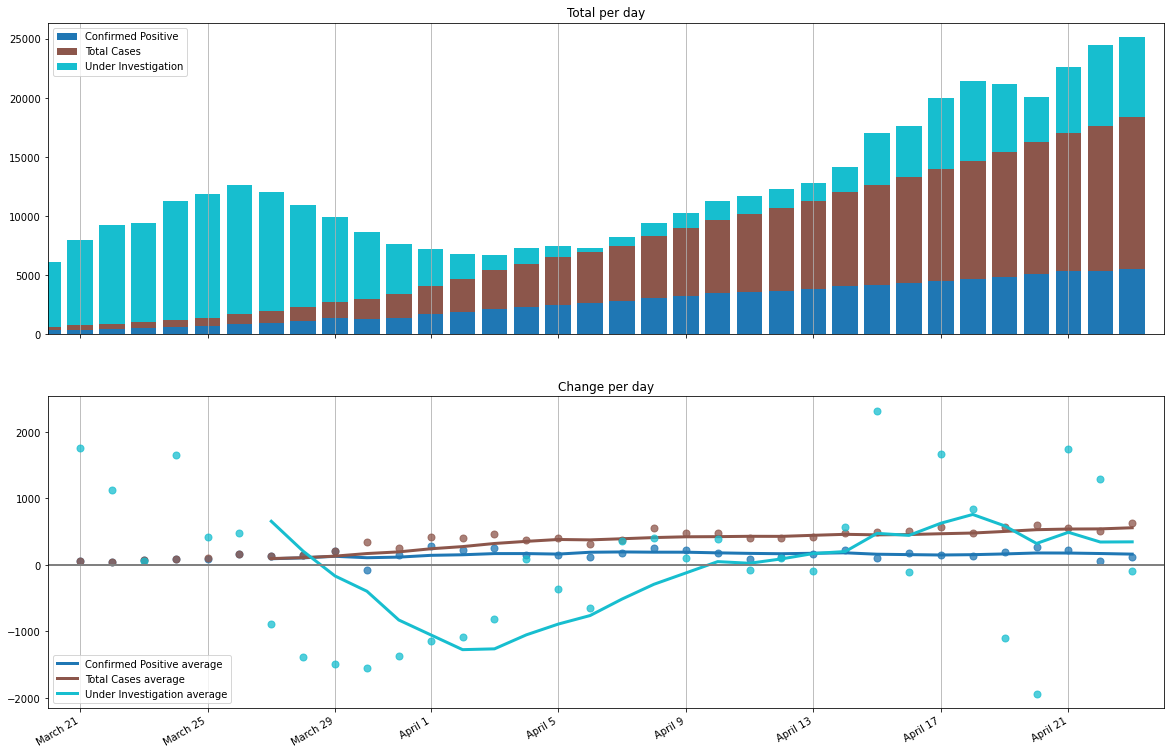

In [20]:
case_cols = ["Confirmed Positive", "Total Cases", "Under Investigation"]
cases = tests[case_cols]
fig = plot_timeline(cases, "2020-03-20", colormap="tab10")
plt.show()

# Investigate Detailed dataset: Confirmed positive COVID-19 cases in Ontario

In [21]:
dataset = "Confirmed positive cases of COVID-19 in Ontario"
url_website = get_website_url(dataset)
url_dataset = get_data_urls(url_website)
paths_dataset = fetch_test_data(url_dataset)

File already exists: data/2020-04-24/conposcovidloc.csv. Skipping download.
File already exists: data/2020-04-24/conposcovidloc.geojson. Skipping download.


## Tabular data

Load the first file: tabular data from a CSV

In [22]:
pos_csv = load_test_data(paths_dataset[0])

In [23]:
pos_csv.tail()

,Row_ID,Accurate_Episode_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Outcome1,Reporting_PHU,Reporting_PHU_Address,Reporting_PHU_City,Reporting_PHU_Postal_Code,Reporting_PHU_Website,Reporting_PHU_Latitude,Reporting_PHU_Longitude
12874,12875,2020-04-17,50s,MALE,Information pending,Not Resolved,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358
12875,12876,2020-04-17,70s,MALE,Information pending,Not Resolved,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358
12876,12877,2020-04-12,80s,FEMALE,Information pending,Not Resolved,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358
12877,12878,2020-04-02,70s,OTHER,Information pending,Resolved,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358
12878,12879,2020-04-17,50s,FEMALE,Information pending,Not Resolved,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358


Clean it up

In [24]:
outcomes = pos_csv.rename(columns={
    "Accurate_Episode_Date": "date",
    "Case_AcquisitionInfo": "acquisition",
    "Age_Group": "age",
    "Client_Gender": "gender",
    "Reporting_PHU_City": "city",
    "Outcome1": "outcome"
})

In [25]:
outcomes["date"] = pd.to_datetime(outcomes["date"])

In [26]:
def get_value_counts_timeseries(df, col_name):
    """Return a timeseries of how many counts there are of each value in col_name per day."""
    col_values = df[col_name].unique()
    # Create a new DataFrame to store counts per date
    bool_cols = pd.DataFrame(data=df["date"])
    # Add a new column for each value, showing whether the record matches that value
    for col in col_values:
        bool_cols[col] = (df[col_name] == col)
    # Aggregate over days to return a timeseries
    col_values_ts = bool_cols.groupby("date").sum()
    return col_values_ts

### Plot: timeseries of outcome counts

In [27]:
outcome_ts = get_value_counts_timeseries(outcomes, "outcome")

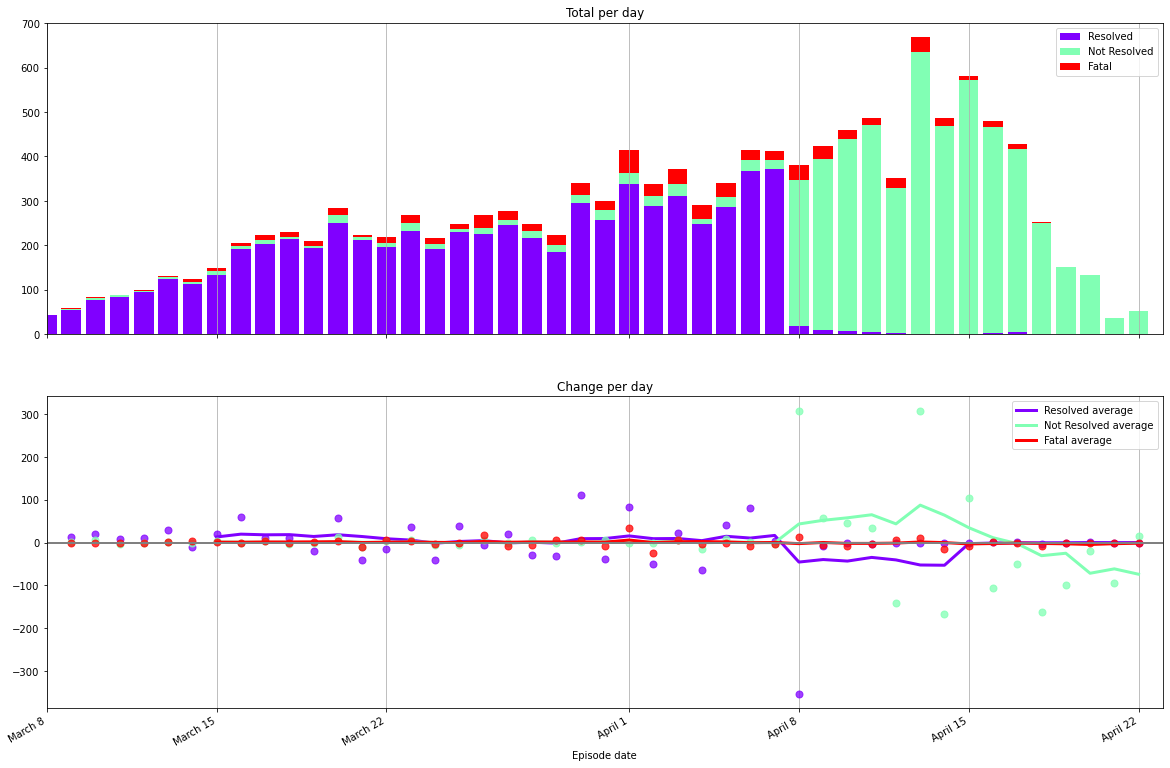

In [28]:
fig = plot_timeline(outcome_ts, "2020-03-08", colormap="rainbow")
plt.xlabel("Episode date")
plt.show()

### Plot: timeseries of cases by city

Rename the cities outside of the ones with the most cases "other"

In [29]:
# Get the top cities
num_cities = 9
city_hotspots = outcomes["city"].value_counts().head(num_cities).index
mask_not_hotspot = ~outcomes["city"].isin(city_hotspots)
# Create a new column with just the top cities, and rename any other cities "other"
outcomes["city_group"] = outcomes["city"]
outcomes.loc[mask_not_hotspot, "city_group"] = "Other"

In [32]:
city_ts = get_value_counts_timeseries(outcomes, "city_group")

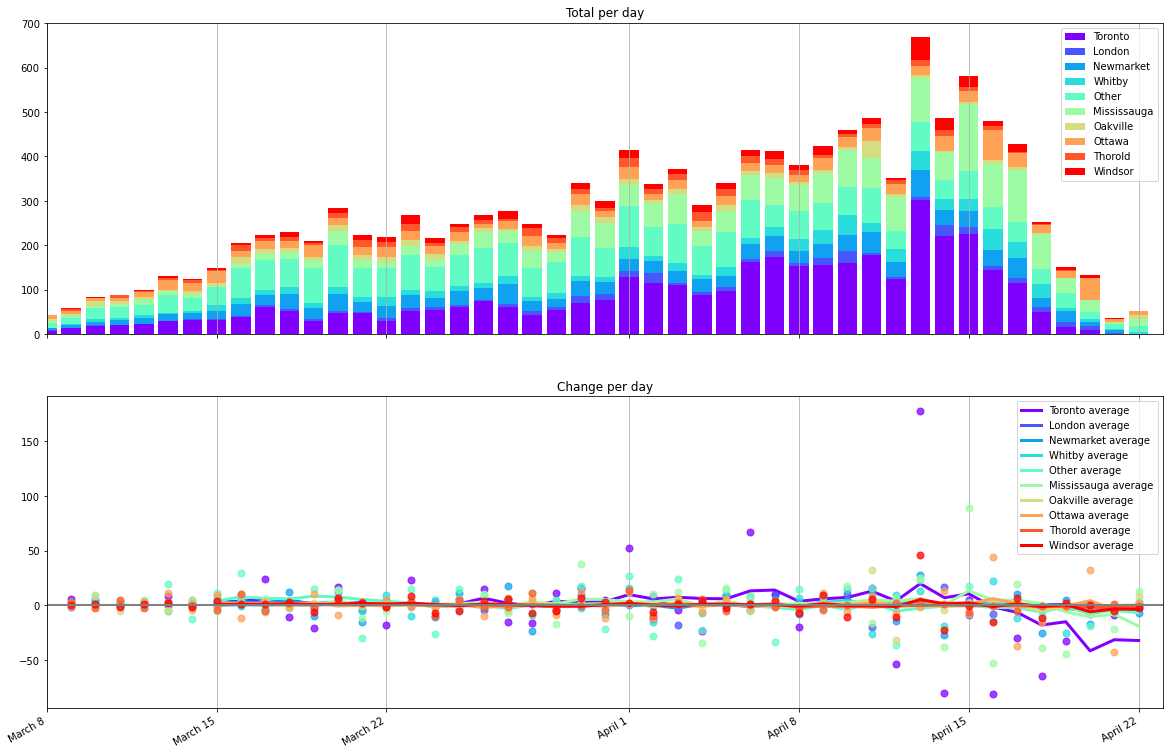

In [33]:
fig = plot_timeline(city_ts, start_date="2020-03-08")
plt.show()

### Plot: timeseries of cases by age group

In [39]:
age_ts = get_value_counts_timeseries(outcomes, "age")
age_ts = age_ts[["20s", "30s", "40s", "50s", "60s", "70s", "80s", "90s"]]

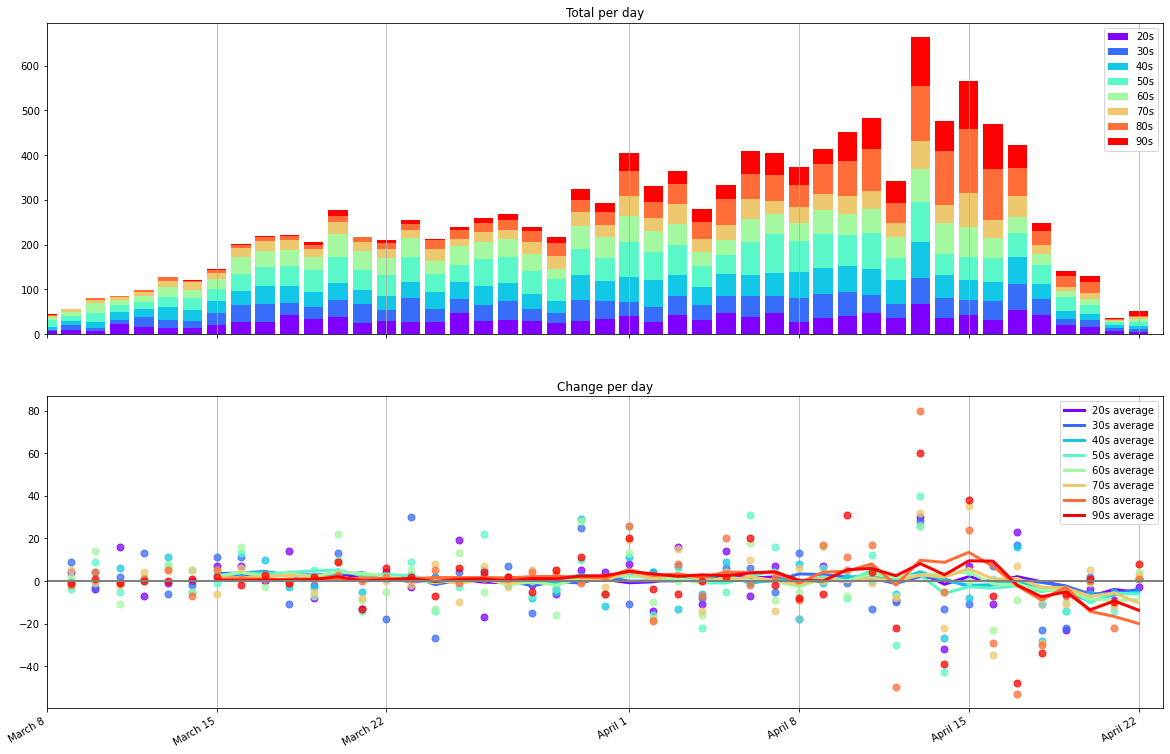

In [41]:
fig = plot_timeline(age_ts, start_date="2020-03-08", colormap="rainbow")
plt.show()

### Plot: timeseries of cases by acquisition type

In [166]:
acquisition_ts = get_value_counts_timeseries(outcomes, "acquisition")

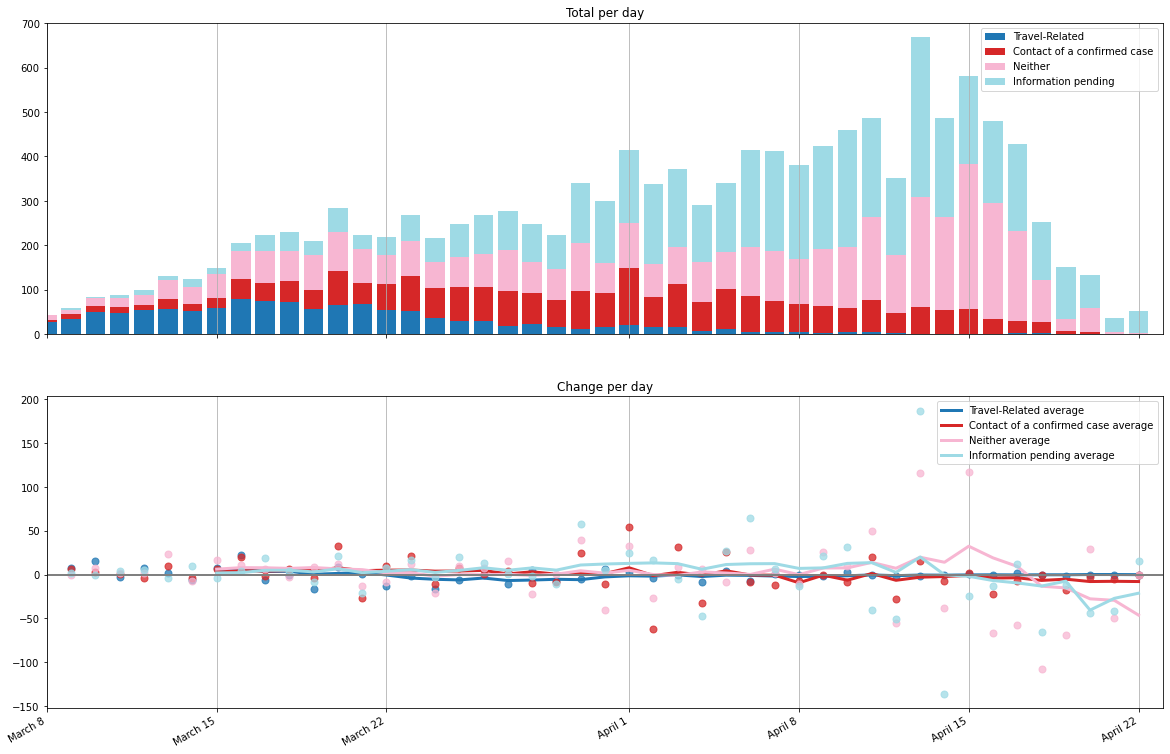

In [168]:
fig = plot_timeline(acquisition_ts, start_date="2020-03-08", colormap="tab20")
plt.show()

### Plot: mortality, disaggregated by group

In [115]:
def mortality_groupby(outcomes, groupby_col_name, allowed_values=[]):
    """Show mortality disaggregated by the values in groupby_col_name."""
    df = outcomes[["Resolved", "Fatal"] + [groupby_col_name]]
    if allowed_values:
        df = df[df[groupby_col_name].isin(allowed_values)]
        
    df_sums = df.groupby(groupby_col_name).sum()
    df_sums["mortality"] = df_sums["Fatal"]/df_sums["Resolved"]
    df_sums["num_cases"] = (df_sums["Fatal"] + df_sums["Resolved"]).astype(int)
    return df_sums[["mortality", "num_cases"]]

In [120]:
def plot_mortality_groupby(mortality_groups, colormap="rainbow"):
    """Plot an hbar of mortalities grouped by category."""
    group_label = mortality_groups.index.name
    
    fig, ax = plt.subplots(figsize=(16,8))

    cmap = plt.get_cmap(colormap)
    for i, mortality_group in enumerate(mortality_groups.index):
        mortality = mortality_groups.loc[mortality_group, "mortality"]
        plt.barh(
            y=mortality_group, 
            width=mortality, 
            color=cmap(mortality)
        )
        ax.text(
            x=mortality + 0.0075, 
            y=i - 0.05,
            s="{:.1%}".format(mortality),
            fontsize=16
        )
        
    ax.set_xlim([0, 1])
    ax.set_title(f"Mortality by {group_label}",fontsize=16)
    ax.set_xlabel("Mortality (%)", fontsize=16)
    ax.set_ylabel(group_label.capitalize(), rotation=0, labelpad=40, fontsize=16)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(1.0))
    ax.grid("on", which="major", axis="x", linestyle="--")
    ax.tick_params(axis='both', which='major', labelsize=16)
    return fig

In [121]:
mortality_groupby(outcomes, "gender", allowed_values=["MALE", "FEMALE"])

,mortality,num_cases
gender,,
FEMALE,0.094562,4086
MALE,0.121867,3268


In [122]:
mortality_age = mortality_groupby(outcomes, "age")
age_exclude = ["<20", "Unknown"]
mortality_age = mortality_age[~mortality_age.index.isin(age_exclude)]
mortality_age

,mortality,num_cases
age,,
20s,0.000000,902
30s,0.002088,960
40s,0.008137,1115
50s,0.020301,1357
60s,0.051440,1022
70s,0.267161,683
80s,0.622066,691
90s,0.837209,474


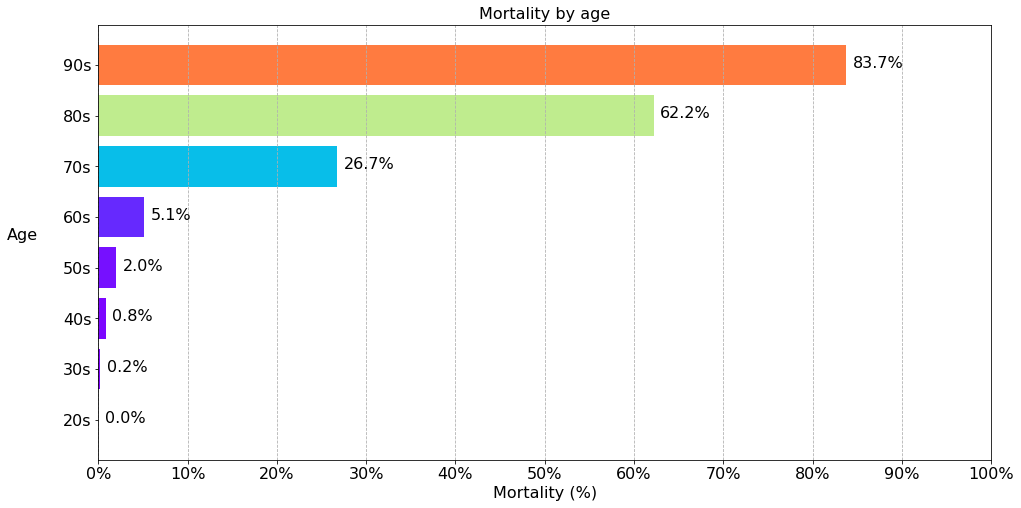

In [123]:
fig = plot_mortality_groupby(mortality_age)
plt.show()

In [124]:
mortality_cities = mortality_groupby(outcomes, "city")
mortality_cities = mortality_cities[mortality_cities["num_cases"] > 250].sort_values(by="mortality")

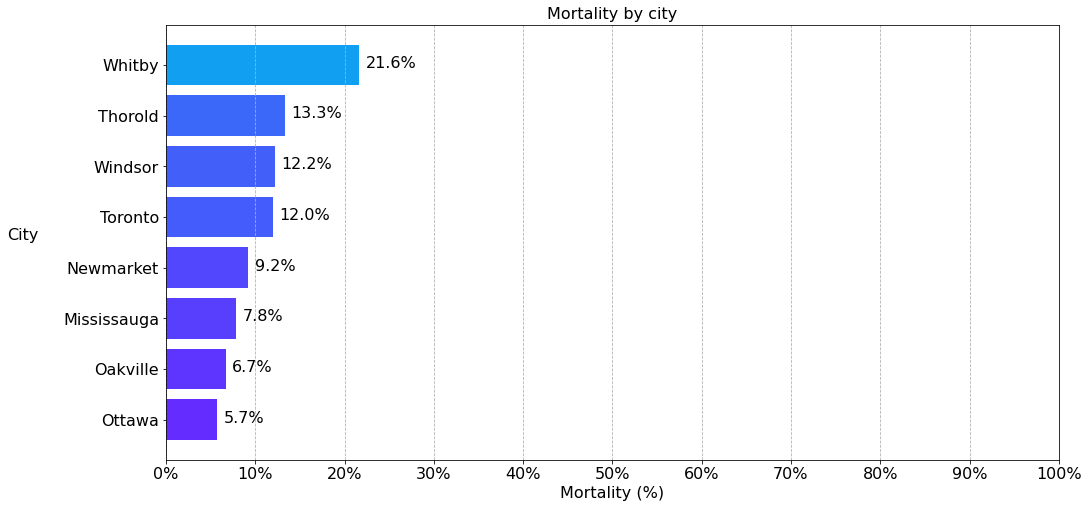

In [126]:
fig = plot_mortality_groupby(mortality_cities)
plt.show()

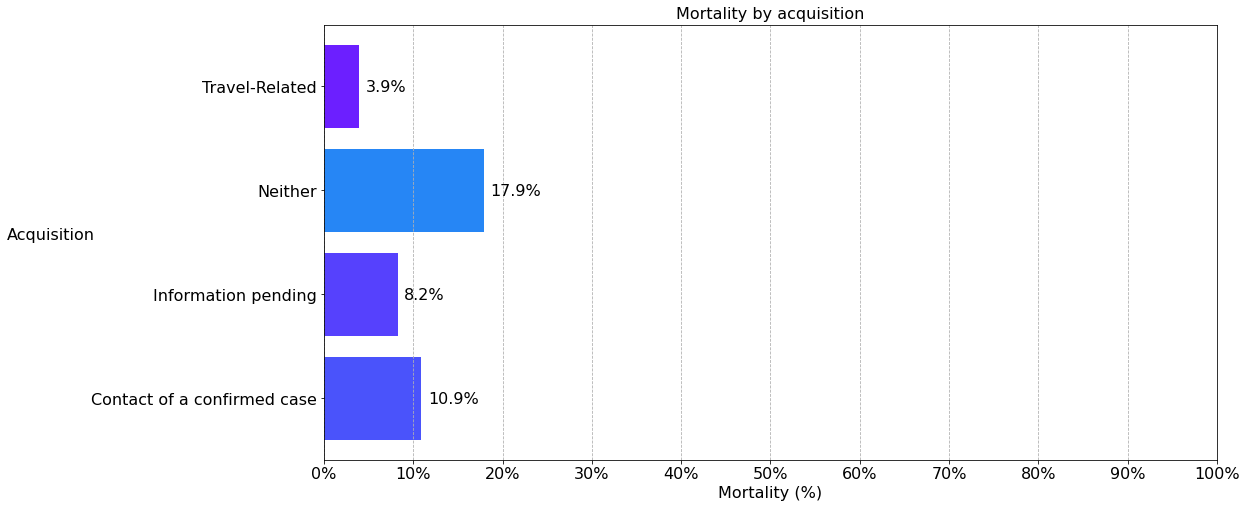

In [174]:
mortality_acquisition = mortality_groupby(outcomes, "acquisition")
fig = plot_mortality_groupby(mortality_acquisition)
plt.show()

## Investigate geographical data

Load the second file: geographic data from the geoJSON

In [27]:
filename_geojson = paths_dataset[1]
with open(filename_geojson, "rb") as f:
    pos_geo = gpd.read_file(f)

In [28]:
pos_geo.tail()

,Case_AcquisitionInfo,Reporting_PHU_Postal_Code,Client_Gender,OBJECTID,Accurate_Episode_Date,Outcome1,Reporting_PHU_City,Reporting_PHU_Latitude,Reporting_PHU_Website,Row_ID,_id,Age_Group,Reporting_PHU_Longitude,Reporting_PHU,geometry
11730,Information pending,M5B 1W2,FEMALE,11731,2020-03-30T00:00:00,Resolved,Toronto,43.656591,www.toronto.ca/community-people/health-wellnes...,11731,11731,30s,-79.379358,Toronto Public Health,POINT (-79.37936 43.65659)
11731,Information pending,M5B 1W2,FEMALE,11732,2020-04-09T00:00:00,Not Resolved,Toronto,43.656591,www.toronto.ca/community-people/health-wellnes...,11732,11732,60s,-79.379358,Toronto Public Health,POINT (-79.37936 43.65659)
11732,Information pending,M5B 1W2,FEMALE,11733,2020-04-10T00:00:00,Not Resolved,Toronto,43.656591,www.toronto.ca/community-people/health-wellnes...,11733,11733,50s,-79.379358,Toronto Public Health,POINT (-79.37936 43.65659)
11733,Contact of a confirmed case,M5B 1W2,MALE,11734,2020-04-10T00:00:00,Not Resolved,Toronto,43.656591,www.toronto.ca/community-people/health-wellnes...,11734,11734,30s,-79.379358,Toronto Public Health,POINT (-79.37936 43.65659)
11734,Information pending,M5B 1W2,MALE,11735,2020-04-16T00:00:00,Not Resolved,Toronto,43.656591,www.toronto.ca/community-people/health-wellnes...,11735,11735,20s,-79.379358,Toronto Public Health,POINT (-79.37936 43.65659)


In [31]:
southern_ontario_box =  box(-83.58, 41.95, -73.46, 45.54)
southern_ontario_mask = pos_geo["geometry"].within(southern_ontario_box) 
southern_ontario_cases = pos_geo[southern_ontario_mask]["geometry"]

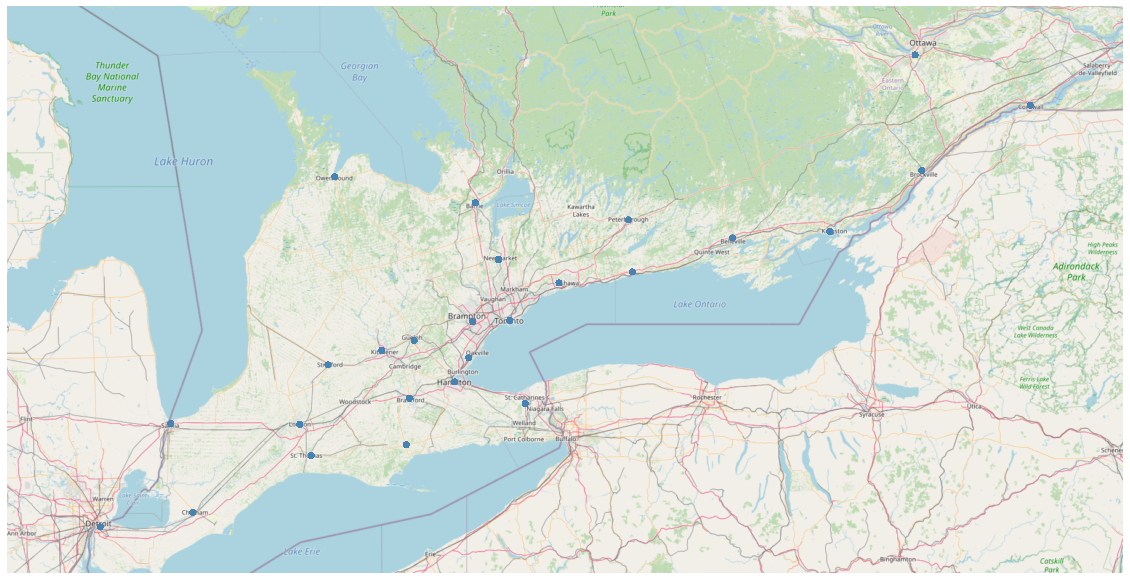

In [32]:
ax = gplt.webmap(
    df=southern_ontario_cases,
    projection=gplt.crs.WebMercator(),
    figsize=(20,18)
)
gplt.pointplot(southern_ontario_cases, ax=ax)

In [141]:
pos_geo["geometry"].astype(str).nunique()

34

In [33]:
pos_geo["geo_str"] = pos_geo["geometry"].astype(str)
pos_geo.groupby(["geo_str"])["Reporting_PHU"].nunique()

geo_str
POINT (-74.73629778999999 45.02915233)    1
POINT (-75.70283308 44.61584261)          1
POINT (-75.76391219999999 45.3456651)     1
POINT (-76.5252108 44.2278735)            1
POINT (-77.11872700000001 45.799406)      1
POINT (-77.39144554000001 44.18667362)    1
POINT (-78.28579239 43.96817279)          1
POINT (-78.32134748 44.30163229)          1
POINT (-78.940341 43.898605)              1
POINT (-79.2412197 43.1165366)            1
POINT (-79.37935801 43.65659125)          1
POINT (-79.46784049999999 46.31320706)    1
POINT (-79.480239 44.048023)              1
POINT (-79.68163199999999 47.5092835)     1
POINT (-79.68630597000001 44.41071258)    1
POINT (-79.7088933 43.6474713)            1
POINT (-79.74479581 43.41399692)          1
POINT (-79.87134089 43.2576311)           1
POINT (-80.2337433 43.5248813)            1
POINT (-80.27437415 43.151811)            1
POINT (-80.30381491 42.84782526)          1
POINT (-80.52091315 43.46287573)          1
POINT (-80.94097993 44.5

Well, it looks like all that the geography data gives is the lat/long of the public health reporting unit. And there's only 34 of them. That's not very interesting.

The most interesting thing we can use the geodata for is to disaggregate case data by census region. Maybe we can compare to population density. Let's try that next.
